# Multilabel Image Classification using MXNet

#### Determine elements from chemical structure images. All images are from the awesome PubChem.com

### Install necessary Package and Set CUDA to 1 for GPU

In [ ]:
!pip install mxnet
!pip install mxnet-cu92
!pip install nltk
!pip install -U sacremoses
!pip install matplotlib
!pip install gluoncv
!pip install pandas
USE_CUDA=1

#!pip install gluonnlp

### Import necessary packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from multiprocessing import cpu_count

import mxnet as mx
from mxnet import nd, gluon
from mxnet.gluon.data.vision import transforms

from deep_abyasa import Download
from deep_abyasa import TrainingHelpers
from deep_abyasa import Encode_Labels
from deep_abyasa import JsonIndexMultiLabelDataset

### Application Constants

In [2]:
paths = './chem_struct_to_elem/'
img_path = 'images'
train = 'chem_train.json'
test = 'chem_test.json'

num_gpus = -1
ctx = TrainingHelpers.get_ctx(num_gpus)
CPU_COUNT = cpu_count()

### Hyperparameters

In [3]:
lr = 1
momentum = 0.9
wd = 0.0001
batch_size = 8

### Download necessary files if they don't already exists

    1.Download dataset from google clould
    2.Extract contents
    3.Download includes: 
        a. Index file for train and test files. 
        b. Index file is a json file that contains image names and labels
        c. pickle file that has lables (This is not used in this example)
        d. Images (Chemical structures)
        

In [4]:
Download('chem_struct_to_elem')

./chem_struct_to_elem.tar.gz exists. Nothing will be downloaded
./chem_struct_to_elem exists. Nothing will be unzipped


### Extract labels and create itol and ltoi

In [4]:
itol, ltoi = Encode_Labels.encode_from_index_files(root=paths, 
                                                   label_col='elements',
                                                   files=[train, test],
                                                   multi_label=True)

labels = ltoi

### Transformations to be applied on images. 

In [5]:
transform = transforms.Compose([
    transforms.Resize(300),
    #transforms.RandomResizedCrop(224),
    #transforms.RandomBrightness(0.1),
    transforms.RandomSaturation(.1),
    transforms.RandomContrast(.1),
    transforms.RandomColorJitter(.1),
    transforms.RandomHue(.1),
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

### Create train and test datasets and data loaders

In [6]:
train_ds = JsonIndexMultiLabelDataset(paths, train, 'images', "file", "elements", 
                                      transform=transform, one_hot_encode_labels=True,
                                      labels=labels)
test_ds = JsonIndexMultiLabelDataset(paths, test, 'images', "file", "elements", 
                                      transform=transform, one_hot_encode_labels=True,
                                      labels=labels)

train_dl = mx.gluon.data.DataLoader(train_ds, batch_size=batch_size, num_workers=CPU_COUNT)
test_dl = mx.gluon.data.DataLoader(test_ds, batch_size=batch_size, num_workers=CPU_COUNT)

Since Labels are provided, this will be used for one hot encoding
Since Labels are provided, this will be used for one hot encoding


### View an image

8
10091.0


(3, 300, 300)

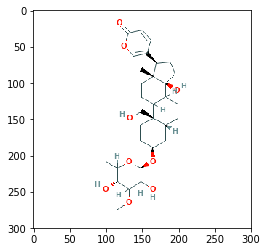

In [7]:
print(train_dl._batch_sampler._batch_size)
image, codes, names = train_ds.__getitem__(89)
plt.imshow(nd.transpose(image, (1,2,0)).asnumpy())
print(names)
image.shape

### Load model 

In [12]:
net = TrainingHelpers.get_model('ResNet18_v2', ctx, len(labels), model_param=f'{paths}net_11_90.params')

### Create Gluon Trainer and Loss Function

In [13]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {
                        'learning_rate': lr, 'momentum': momentum, 'wd': wd})
Loss_func = gluon.loss.SigmoidBinaryCrossEntropyLoss()

### Begin Training

In [ ]:
temp = TrainingHelpers.train(train_dl, test_dl, net, trainer, Loss_func, epochs=1, num_gpus=num_gpus)

### Predict for a random image

In [15]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

TrainingHelpers.predict(net, f'{paths}/{img_path}', "8288.png", itol, transform=transform_test)

['carbon', 'chlorine', 'hydrogen', 'nitrogen', 'oxygen']